# 实验五：层次聚类
- 姓名：徐文斌
- 学号：2010234
- 专业：计算机科学与技术

## 实验要求

### 基本要求
a) 实现single-linkage层次聚类算法； b) 实现complete-linkage层次聚类算法；
### 中级要求
a) 实现average-linkage层次聚类算法； b) 将上述三种算法的性能进行简要对比；
### 高级要求
通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析；

## 基本&中级要求

### 数据生成

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
import numpy as np

MAX_NUM = 1e3

def create_data(centers,num=100,std=0.7):
    '''
    生成用于聚类的数据集
    :param centers: 聚类的中心点组成的数组。如果中心点是二维的，则产生的每个样本都是二维的。
    :param num: 样本数
    :param std: 每个簇中样本的标准差
    :return: 用于聚类的数据集。是一个元组，第一个元素为样本集，第二个元素为样本集的真实簇分类标记
    '''
    X, labels_true = make_blobs(n_samples=num, centers=centers, cluster_std=std)
    return  X, labels_true


def plot_data(*data):
    '''
    绘制用于聚类的数据集
    :param data: 可变参数。它是一个元组。元组元素依次为：第一个元素为样本集，第二个元素为样本集的真实簇分类标记，第三个元素为预测分类标记
    :return: None
    '''
    X,labels_true,labels_predict,cnt=data
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    colors='rgbyckm' # 每个簇的样本标记不同的颜色
    markers='o^sP*DX'
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],label="cluster %d"%labels_true[i],
        color=colors[predict%len(colors)],marker=markers[labels_true[i]%len(markers)],alpha=0.5)

centers=[[1,1,1],[1,3,3],[3,6,5],[2,6,8]]# 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
X,labels_true= create_data(centers,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
np.savetxt('./data.dat',X)
np.savetxt('./label.dat',labels_true)
print("generate data finish!")

generate data finish!


### single-linkage层次聚类算法

In [2]:
def singleLinkage(X):
    # your code
    min_x = []
    for i in range(len(X[0])):
        min_x.append(min(X[0][i], X[1][i]))
    return min_x

### complete-linkage层次聚类算法

In [3]:
def completeLinkage(X):
    # your code
    max_x = []
    for i in range(len(X[0])):
        max_x.append(max(X[0][i], X[1][i]))
    return max_x

### average-linkage层次聚类算法

In [4]:
def averageLinkage(X, num1, num2):
    # your code
    avg = []
    for i in range(len(X[0])):
        avg.append((X[0][i] * num1 + X[1][i] * num2) / (num1 + num2))
    return avg

In [5]:
class AgglomerativeClustering:
    def __init__(self):
        # 对每次的合并进行记录
        self.steps=[]

    def fit(self,datas,method):
        self.dataCnt = datas.shape[0]
        # 预处理各点之间的距离
        allDist = np.zeros((self.dataCnt,self.dataCnt))
        for i in range(self.dataCnt):
            for j in range(i):
                allDist[i][j] = allDist[j][i] = np.sum((datas[i]-datas[j])**2)
        setList, clusterCount = [[i] for i in range(self.dataCnt)], self.dataCnt
        print("calculate distance finish!")

        # 聚类间距离矩阵
        clusterDist = np.zeros((self.dataCnt,self.dataCnt))+MAX_NUM
        for i in range(clusterCount):
            for j in range(i+1,clusterCount):
                clusterDist[i][j] = clusterDist[j][i] = allDist[i][j]
        print("calculate cluster distance finish!")

        while clusterCount != 1:
            # 最相似的两个聚类
            res = np.argmin(clusterDist)
            dest,src = int(res/clusterCount),res%clusterCount
            # steps进行一次记录
            self.steps.append((setList[dest][0],setList[src][0]))
            # 聚类间距离矩阵更新
            if method == averageLinkage:
                modify = method(clusterDist[[dest,src]], len(setList[dest]), len(setList[src]))
            else:
                modify = method(clusterDist[[dest,src]])
            clusterDist[dest] = modify
            clusterDist[:,dest] = modify
            clusterDist = np.delete(clusterDist,src,axis=0)
            clusterDist = np.delete(clusterDist,src,axis=1)
            clusterDist[dest][dest] = MAX_NUM
            # 聚类更新
            setList[dest] = setList[dest] + setList[src]
            del setList[src]
            clusterCount -= 1
#             if (self.dataCnt - clusterCount) % (self.dataCnt / 20) == 0:
#                 print(clusterCount, " clusters left.")

        print("cluster finish !")

    def label(self, k):
        root = list(range(self.dataCnt))
        def find_root(n):
            if root[root[n]] == root[n]:
                return root[n]
            root[n]=find_root(root[n])
            return root[n]
        for i in range(self.dataCnt-k): # 根据steps记录产生非连通图
            src,dest = self.steps[i]
            root[find_root(dest)] = find_root(src)
        cluster, clusterNum = [0 for i in range(self.dataCnt)], 0
        for i in range(self.dataCnt): # 将根节点标注为新的cluster
            if i == root[i]: # i是根
                clusterNum += 1
                cluster[i] = clusterNum
        for i in range(self.dataCnt): # 将非根节点标注为根节点的cluster
            if i != root[i]: # i不是根
                cluster[i] = cluster[find_root(i)]
        return cluster

### 进行测试

In [6]:
# 求列表的全排列
def permutation(li):
    len_list = len(li)
    if len_list == 1:
        return [li]
    result = []
    for i in range(len_list):
        res_list = li[:i] + li[i + 1:]
        per_result = permutation(res_list)
        result += [li[i:i + 1] + j for j in per_result]
    return result

In [7]:
# 计算准确率
def accCal(predict, k):
    max_acc = 0
    perm = permutation([i for i in range(k)])
    for labels in perm:
        accNum = 0
        for i in range(len(predict)):
            if labels_true[i] == labels[predict[i] - 1]:
                accNum += 1
        acc = accNum / len(labels_true)
        max_acc = max(max_acc, acc)
    return max_acc

In [8]:
def test(methods, k, draw_pic=True):
    accs = []
    cnt = 0
    for method in methods:
        model = AgglomerativeClustering()
        model.fit(X, method)
        predict = model.label(k)
        right_num = 0
        if draw_pic:
            plot_data(X, labels_true, predict, cnt)
        acc = accCal(predict, k)
        accs.append(acc)
        cnt += 1
        print(f"正确率：{acc * 100}%")
        print("-------Segmentation-------")
    return accs

calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：50.1%
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：99.3%
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：99.4%
-------Segmentation-------


[0.501, 0.993, 0.994]

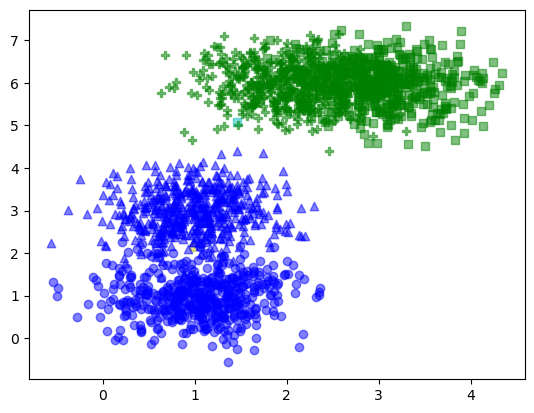

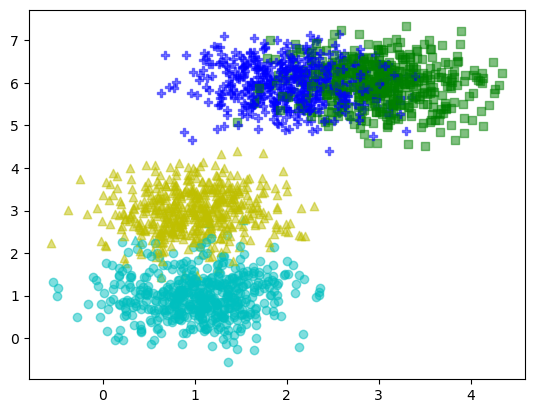

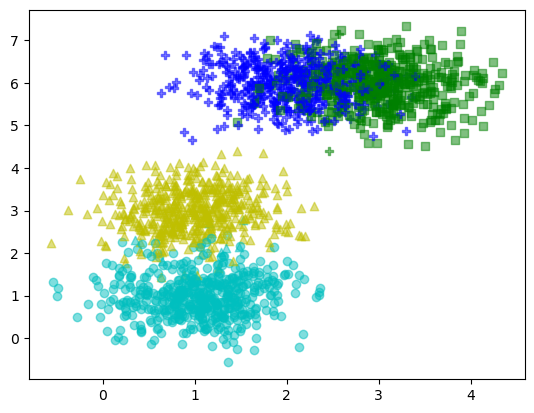

In [9]:
METHOD_APPLY = [singleLinkage, completeLinkage, averageLinkage]
test(METHOD_APPLY, 4)

从上方结果可以看出，当聚类个数为4时，最小连接距离法性能最差，正确率仅有50%左右。而最大连接距离法与平均连接距离法则性能较好，且两者相差不大，聚类正确率接近100%。

## 高级要求

这里我们将聚类个数从1到8分别进行测试。

In [10]:
ks = [i + 1 for i in range(8)]
accs = []
for k in ks:
    print(f"----------------k={k}-------------------")
    accs.append(test(METHOD_APPLY, k, False))

----------------k=1-------------------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：25.0%
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：25.0%
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：25.0%
-------Segmentation-------
----------------k=2-------------------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：25.0%
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：25.0%
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：25.0%
-------Segmentation-------
----------------k=3-------------------
calculate distance finish!
calculate cluster distance finish!
cluster finish !
正确率：50.05%
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
cluster 

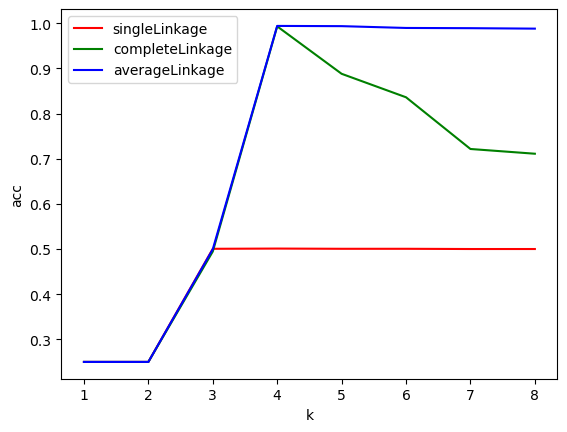

In [11]:
plt.xlabel("k")
plt.ylabel("acc")
acc1 = [i[0] for i in accs]
acc2 = [i[1] for i in accs]
acc3 = [i[2] for i in accs]
plt.plot(ks, acc1, 'r')
plt.plot(ks, acc2, 'g')
plt.plot(ks, acc3, 'b')
plt.legend(['singleLinkage','completeLinkage', 'averageLinkage'])
plt.show()

如上图所示，更改聚类簇的个数后重新进行聚类。可以看到，当聚类个数比较小时，三种算法的正确率均较低，可能是由于聚类能力限制，无法分出全部类别，因此性能较低。随着聚类簇个数的变大，最小连接距离法的正确率依旧很差，仅有50%左右，而最大连接距离法与平均连接距离法性能则会提高，当聚类个数为4时，二者正确率均逐渐接近100%。之后继续增大聚类个数，平均连接距离法正确率不再发生大的改变，而最大连接距离法的正确率则是逐渐下降。

通过分析三种算法，可以得出结论：
- SingleLinkage容易造成两个聚类明明从“大局”上离得比较远，但是由于其中个别的点距离比较近就被合并了，并且这样合并之后这种情况会进一步扩大，最后会得到比较松散的聚类。
- CompleteLinkage会导致两个cluster即使已经很接近了，但是只要有不配合的点存在，就不会合并。这两种相似度的定义方法的共同问题就是只考虑了某个有特点的数据，而没有考虑类内数据的整体特点。
- Average-linkage:这种方法就是把两个集合中的点两两的距离全部放在一起求一个平均值，相对也能得到合适一点的结果。考虑了整体情况，不会因为某些极端值或边界上的点影响整体结果。